In [1]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
os.chdir('/local/crv/acanberk/folding-unfolding/src')
from learning.utils import deformable_distance
import pandas as pd
os.chdir('/local/crv/acanberk/folding-unfolding/src')
from learning.utils import deformable_distance
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import rotate
import seaborn as sns
import cv2

input_paths = {
    'gt':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/gt/replay_buffer.hdf5',
    'all':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/mixed-2/replay_buffer.hdf5',
    'unfactorized':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/unfactorized/replay_buffer.hdf5',
    'factorized':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/factorized/replay_buffer.hdf5',
    'fling':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/fling/replay_buffer.hdf5',
    'garbage':'/local/crv/acanberk/folding-unfolding/src/downstream_experiments/garbage/replay_buffer.hdf5'
}


def collect_data(group):

    instance_query = int(np.array(group['init_verts']).shape[0])
    mask = np.array(group['postaction_curr_mask'])
    init_mask = np.array(group['postaction_init_mask'])
    curr_verts = np.array(group['postaction_verts'])
    preaction_verts = np.array(group['preaction_verts'])
    pretransform_image = group['pretransform_observations'][:3].transpose(1,2,0)
    image = group['next_observations'][:3].transpose(1,2,0)
    init_verts = np.array(group['init_verts'])
    area = (init_verts[0].max() - init_verts[0].min()) * (init_verts[2].max() - init_verts[2].min())

    preaction_l2_distance = group.attrs['preaction_pointwise_distance']
    preaction_deformable_distance = group.attrs['preaction_l2_distance']
    preaction_rigid_distance = group.attrs['preaction_icp_distance']
    preaction_iou = group.attrs['preaction_iou']

    retval = {
        'instance_query':instance_query,
        'mask':mask,
        'verts':curr_verts,
        'preaction_verts':preaction_verts,
        'image':image,
        'pretransform_image':pretransform_image,
        'init_verts':init_verts,
        'area':area,
        'init_mask':init_mask,
        'preaction_l2_distance':preaction_l2_distance,
        'preaction_deformable_distance':preaction_deformable_distance,
        'preaction_rigid_distance':preaction_rigid_distance,
        'preaction_iou':preaction_iou,
    }
    return retval




print("Collecting gt data...")
gt_data = {}
path = input_paths['gt']
with h5py.File(path, 'r') as dataset:
    keys = [k for k in list(dataset.keys()) if 'last' in k]
    print("Length of gt keys", len(keys))
    for i, key in enumerate(keys):
        data = collect_data(dataset[key])
        if np.sum(np.logical_xor(data['pretransform_image'].sum(axis=-1), data['init_mask'])) > 10000:
            continue

        gt_data[data['instance_query']] = data

print("Collecting cloth data...")
cloth_data = []
for name, path in input_paths.items():
    print("Collecting from", path)
    with h5py.File(path, 'r') as dataset:
        keys = [k for k in list(dataset.keys()) if 'last' in k]
        for key in keys:
            group = dataset[key]

            episode_data = collect_data(group)
            try:
                gt_instance_data = gt_data[episode_data['instance_query']]
            except:
                print("Query could not be found")
                continue


            mask = episode_data['mask']
            verts = episode_data['verts']
            preaction_verts = episode_data['preaction_verts']
            area = episode_data['area']
            image = episode_data['image']

            gt_mask = gt_instance_data['mask']
            gt_verts = gt_instance_data['verts']
            gt_area = gt_instance_data['area']
            gt_image = gt_instance_data['image']
            gt_preaction_verts = gt_instance_data['preaction_verts']

            def get_edges(im):
                im = np.ascontiguousarray(im.copy() * 255).astype(np.uint8) 
                contours, hierarchy = cv2.findContours(im,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
                out = np.zeros((480, 480)).astype(np.uint8)
                out = cv2.drawContours(out, contours, -1, 255, 3)
                return np.array(out).astype(float)/255

            gt_outline = get_edges(gt_mask)


            if name == 'gt' and (np.sum(np.logical_xor(episode_data['pretransform_image'].sum(axis=-1), episode_data['init_mask'])) > 10000):
                continue
                                
            weighted_distance, deform_distance, rigid_distance, l2_distance , _ = deformable_distance(gt_verts, verts, max_coverage=gt_area)
            iou = np.sum(np.logical_and(mask, gt_mask))/np.sum(np.logical_or(mask, gt_mask))
            rot = -1

            episode_data['iou'] = iou
            episode_data['weighted_distance'] = weighted_distance
            episode_data['deformable_distance'] = deform_distance
            episode_data['rigid_distance'] = rigid_distance
            episode_data['l2_distance'] = l2_distance

            episode_data['preaction_l2_distance'] = episode_data['preaction_l2_distance']
            episode_data['preaction_deformable_distance'] = episode_data['preaction_deformable_distance']
            episode_data['preaction_rigid_distance'] = episode_data['preaction_rigid_distance']
            episode_data['preaction_iou'] = episode_data['preaction_iou']

            episode_data['name'] = name
            episode_data['path'] = path
            episode_data['key'] = key
            episode_data['rot'] = rot
            episode_data['gt_mask'] = gt_outline


            cloth_data.append(episode_data)


cloth_data = pd.DataFrame(cloth_data)
cloth_data.head()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Length of gt keys 190


,instance_query,mask,verts,preaction_verts,image,pretransform_image,init_verts,area,init_mask,preaction_l2_distance,...,iou,weighted_distance,deformable_distance,rigid_distance,l2_distance,name,path,key,rot,gt_mask
0,5820,"[[False, False, False, False, False, False, Fa...","[[0.0070516, 0.007000004, 0.23625757], [0.0071...","[[0.0070997905, 0.007002123, 0.27467364], [0.0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.007393406, 0.007, 0.27361295], [0.00738136...",0.062272,"[[False, False, False, False, False, False, Fa...",0.001042,...,0.661105,0.261245,0.272745,0.239889,0.368476,gt,/local/crv/acanberk/folding-unfolding/src/down...,000000000_step00_last,-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,7612,"[[False, False, False, False, False, False, Fa...","[[0.0017661782, 0.007, 0.29997712], [0.2149891...","[[0.0052969567, 0.007, 0.31675118], [0.2171725...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0053516272, 0.007, 0.31674707], [0.2166404...",0.090749,"[[False, False, False, False, False, False, Fa...",0.000164,...,0.945371,0.019506,0.025483,0.008408,0.026112,gt,/local/crv/acanberk/folding-unfolding/src/down...,000000001_step00_last,-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,6236,"[[False, False, False, False, False, False, Fa...","[[0.0026687735, 0.007, 0.29003048], [0.0024184...","[[0.0018959076, 0.007, 0.29436266], [0.0019639...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.001911175, 0.007, 0.29430076], [0.00198626...",0.073153,"[[False, False, False, False, False, False, Fa...",0.000430,...,0.875039,0.064342,0.072300,0.049563,0.078290,gt,/local/crv/acanberk/folding-unfolding/src/down...,000000002_step00_last,-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,6748,"[[False, False, False, False, False, False, Fa...","[[0.00015745369, 0.0070005627, 0.26939481], [0...","[[0.0027645899, 0.007, 0.26693192], [0.0031774...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0024750312, 0.007, 0.26696953], [0.0027513...",0.059629,"[[False, False, False, False, False, False, Fa...",0.000418,...,0.915486,0.045258,0.050229,0.036025,0.057877,gt,/local/crv/acanberk/folding-unfolding/src/down...,000000003_step00_last,-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,6424,"[[False, False, False, False, False, False, Fa...","[[0.006630207, 0.007, 0.27290097], [0.00643505...","[[0.0068573356, 0.007, 0.27269292], [0.0065789...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.006607055, 0.007, 0.27273268], [0.00630634...",0.059800,"[[False, False, False, False, False, False, Fa...",0.000507,...,0.848214,0.086529,0.083154,0.092796,0.105880,gt,/local/crv/acanberk/folding-unfolding/src/down...,000000004_step00_last,-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [2]:

#select if name is all, fling or gt
select_cloth_data = cloth_data[(cloth_data.name == 'all') | (cloth_data.name == 'factorized') | (cloth_data.name == 'unfactorized')]

preaction_l2_distance = -select_cloth_data.preaction_l2_distance.values
preaction_deformable_distance = -select_cloth_data.preaction_deformable_distance.values
preaction_rigid_distance = -select_cloth_data.preaction_rigid_distance.values
preaction_iou = select_cloth_data.preaction_iou.values

l2_distance = -select_cloth_data.l2_distance.values
deformable_distance = -select_cloth_data.deformable_distance.values
rigid_distance = -select_cloth_data.rigid_distance.values
iou = select_cloth_data.iou.values


1.0
unfactorized_reward vs fold l2_distance: 0.745
unfactorized_reward vs fold iou: 0.826
unfactorized_reward vs fold success: nan
unfactorized_reward vs fold rigid_distance: 0.727
unfactorized_reward vs fold deformable_distance: 0.810


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


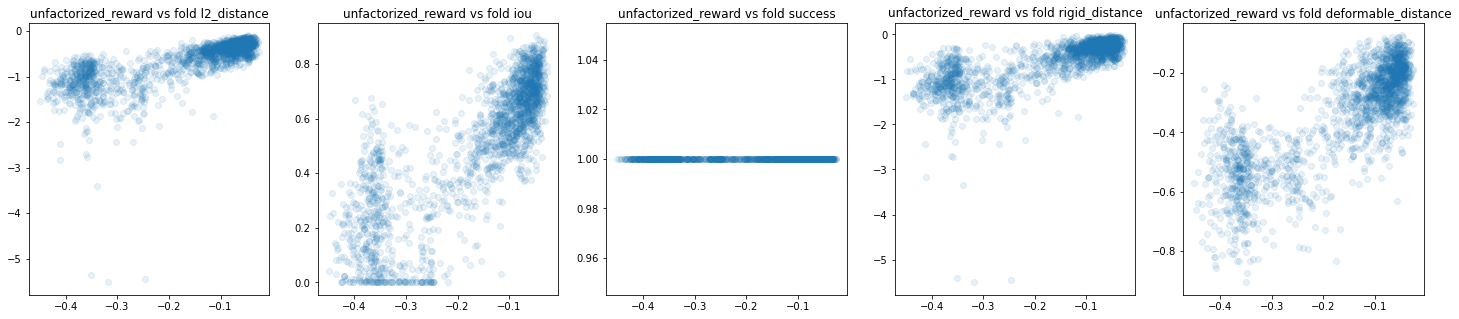

factorized_reward_0.30 vs fold l2_distance: 0.707
factorized_reward_0.30 vs fold iou: 0.771
factorized_reward_0.30 vs fold success: nan
factorized_reward_0.30 vs fold rigid_distance: 0.692
factorized_reward_0.30 vs fold deformable_distance: 0.786


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


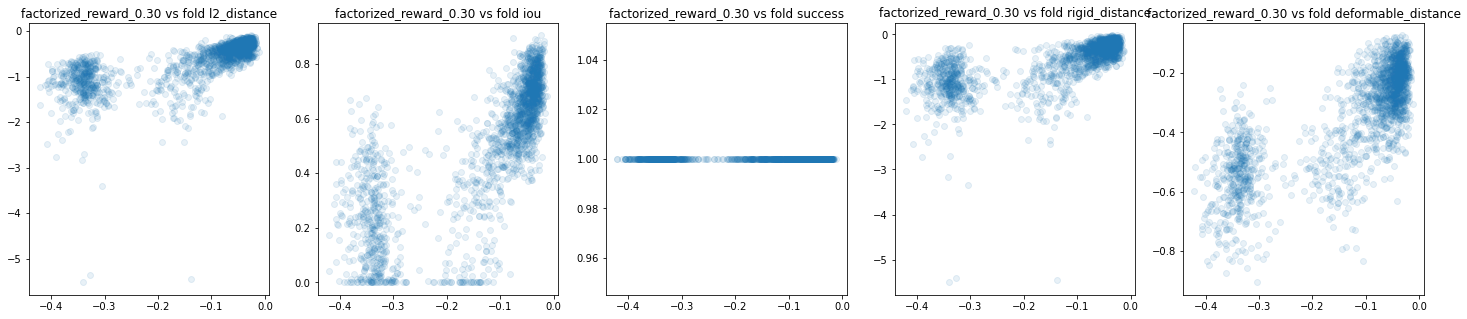

factorized_reward_0.40 vs fold l2_distance: 0.721
factorized_reward_0.40 vs fold iou: 0.785
factorized_reward_0.40 vs fold success: nan
factorized_reward_0.40 vs fold rigid_distance: 0.705
factorized_reward_0.40 vs fold deformable_distance: 0.802


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


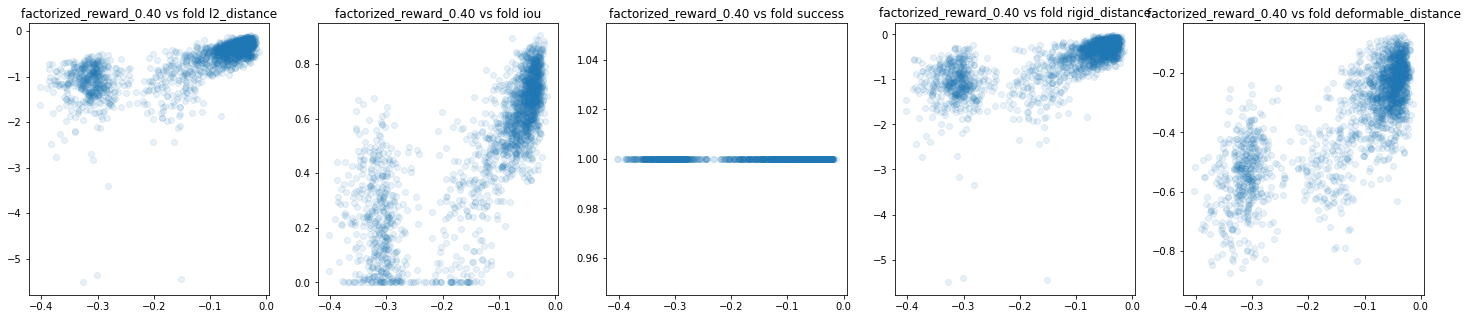

factorized_reward_0.50 vs fold l2_distance: 0.735
factorized_reward_0.50 vs fold iou: 0.799
factorized_reward_0.50 vs fold success: nan
factorized_reward_0.50 vs fold rigid_distance: 0.718
factorized_reward_0.50 vs fold deformable_distance: 0.818


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


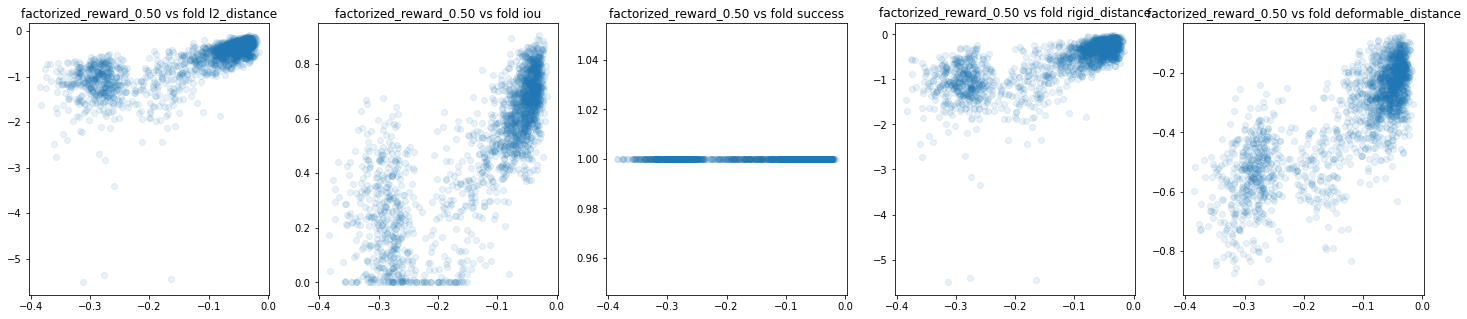

factorized_reward_0.60 vs fold l2_distance: 0.746
factorized_reward_0.60 vs fold iou: 0.809
factorized_reward_0.60 vs fold success: nan
factorized_reward_0.60 vs fold rigid_distance: 0.729
factorized_reward_0.60 vs fold deformable_distance: 0.831


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


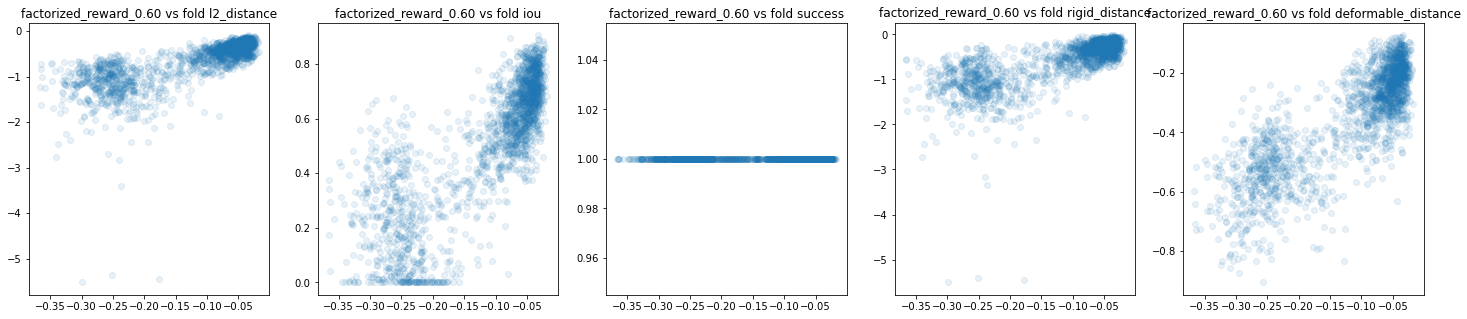

factorized_reward_0.70 vs fold l2_distance: 0.753
factorized_reward_0.70 vs fold iou: 0.815
factorized_reward_0.70 vs fold success: nan
factorized_reward_0.70 vs fold rigid_distance: 0.735
factorized_reward_0.70 vs fold deformable_distance: 0.840


/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/crv/acanberk/mambaforge/envs/interactive-cloth-perception/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


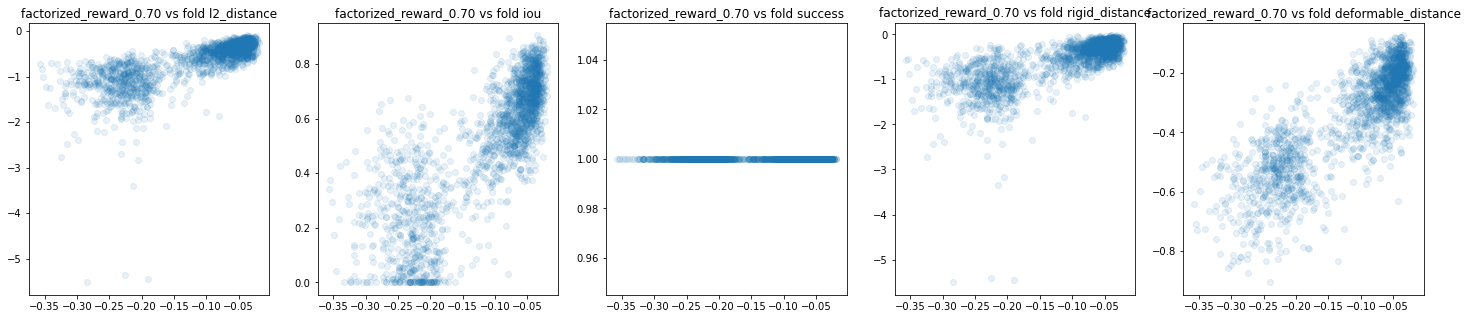

In [3]:


preaction_metrics = []
preaction_metrics.append(("unfactorized_reward", preaction_l2_distance))
for a in np.linspace(0.3, 0.7, 5):
    preaction_metrics.append((f"factorized_reward_{a:.2f}", preaction_deformable_distance * a + preaction_rigid_distance * (1-a)))

postaction_metrics = []

deformable_bound = 0.3
rigid_bound = 0.4

success_mask = np.logical_and(deformable_distance > deformable_bound, rigid_distance > rigid_bound).astype(np.float32)
print(success_mask.mean())

postaction_metrics.append(("fold l2_distance", l2_distance))
postaction_metrics.append(("fold iou", iou))
postaction_metrics.append(("fold success", success_mask))
postaction_metrics.append(("fold rigid_distance", rigid_distance))
postaction_metrics.append(("fold deformable_distance", deformable_distance))


for name, preaction_metric in preaction_metrics:
    fig, axs = plt.subplots(1, len(postaction_metrics), figsize=(len(postaction_metrics)*5, 1*5))
    for i, (name2, postaction_metric) in enumerate(postaction_metrics):
        print(f"{name} vs {name2}: {np.corrcoef(preaction_metric, postaction_metric)[0, 1]:.3f}")
        axs[i].plot(preaction_metric, postaction_metric, 'o', alpha=0.1)
        axs[i].set_title(f"{name} vs {name2}")

    plt.show()